# Crime per area

# Crime the past years
* types of crimes over time

# Crime seasonality

# Types of crime

# Time of Crime

 data links: https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8/about_data

In [1]:
import time
import pandas as pd
from itertools import islice
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
# from pyspark.sql import functions as F
from pyspark.sql.types import *

In [2]:
from google.cloud import storage

In [3]:
conf = SparkConf().setAll([
    ('spark.executor.memory', '10g'),
    ("spark.executor.cores", "4"),
    ("spark.driver.maxResultSize", "4g"),
    ('spark.driver.memory', '64g'),
    ('spark.num.executors', '36'),
    ('spark.cores.max', '48'),
    ('spark.driver.maxResultSize', '7g'),
    ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
    ('spark.kryoserializer.buffer.max', '2047m'),
    ("spark.sql.broadcastTimeout", "1200"),
    ('spark.driver.cores', '3'),
    ("spark.sql.repl.eagerEval.enabled",True)
])

# Create SparkSession with the configurations
spark = SparkSession.builder \
    .appName("MyApp") \
    .config(conf=conf) \
    .getOrCreate()

In [4]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [5]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []

    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df = blobs_df.style.format({"Size": "{:,.0f}"})

    return blobs_df

In [6]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

In [7]:
# "gs://msca-bdp-amazon/amazon_reviews/"
# 'gs://bdp-david-bucket-1/crime-data/LA-crime-data.csv'
bucket_read = 'bdp-david-bucket-1'


In [8]:
list_blobs(bucket_read, 'crime-data/')

crime-data/	0
crime-data/LA-crime-data.csv	252182065


In [41]:
crime_data = spark.read.csv('gs://bdp-david-bucket-1/crime-data/LA-crime-data.csv', header='true', inferSchema='true', sep=',', quote='"')

In [10]:
crime_data.limit(5)

DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
190326475,03/01/2020 12:00:...,03/01/2020 12:00:...,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,null,0,M,O,101,STREET,null,null,AA,Adult Arrest,510,998,null,null,1900 S LONGWOOD ...,null,34.0375,-118.3506
200106753,02/09/2020 12:00:...,02/08/2020 12:00:...,1800,1,Central,182,1,330,BURGLARY FROM VEH...,1822 1402 0344,47,M,O,128,BUS STOP/LAYOVER ...,null,null,IC,Invest Cont,330,998,null,null,1000 S FLOWER ...,null,34.0444,-118.2628
200320258,11/11/2020 12:00:...,11/04/2020 12:00:...,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502,MULTI-UNIT DWELLI...,null,null,IC,Invest Cont,480,null,null,null,1400 W 37TH ...,null,34.021,-118.3002
200907217,05/10/2023 12:00:...,03/10/2020 12:00:...,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND...,0325 1501,19,M,O,405,CLOTHING STORE,null,null,IC,Invest Cont,343,null,null,null,14000 RIVERSID...,null,34.1576,-118.4387
200412582,09/09/2020 12:00:...,09/09/2020 12:00:...,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,null,0,null,null,101,STREET,null,null,IC,Invest Cont,510,null,null,null,200 E AVENUE 28,null,34.082,-118.213


In [42]:
from pyspark.sql.functions import to_date
crime_data = crime_data.withColumn('date_occ', to_date('DATE OCC', 'MM/dd/yyyy HH:mm:ss')).withColumn('year', year(col('date_occ'))).withColumn('month', month(col('date_occ')))

In [43]:
per_area = crime_data.select('AREA NAME', 'DR_NO').groupBy('AREA NAME').agg(count('DR_NO').alias('amount_of_crimes')).orderBy('amount_of_crimes', ascending = False)

In [12]:
per_area.count()

21

In [13]:
per_area_df = per_area.toPandas()

In [14]:
per_area_df

,AREA NAME,amount_of_crimes
0,Central,69305
1,77th Street,61804
2,Pacific,57823
3,Southwest,57226
4,Hollywood,52286
5,Southeast,50249
6,N Hollywood,50144
7,Olympic,48691
8,Wilshire,48138
9,Rampart,46712


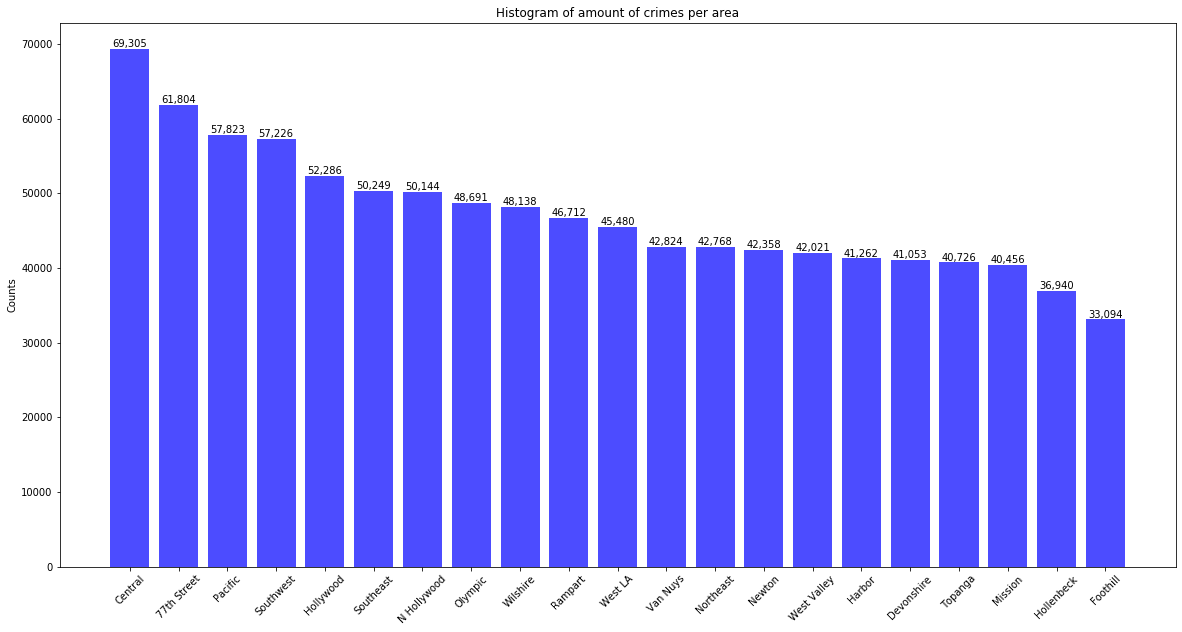

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
fig, axes = plt.subplots(figsize=(20, 10))

# Create bar chart
bars = axes.bar(
    per_area_df['AREA NAME'],
    per_area_df['amount_of_crimes'],
    width=0.8, color='blue', alpha=0.7
)
axes.set_ylabel('Counts')
axes.set_xticklabels(per_area_df['AREA NAME'], rotation=45)
axes.set_title('Histogram of amount of crimes per area')

# add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    axes.text(bar.get_x() + bar.get_width() / 2, height,  # x and y positions
              f'{int(height):,}', #format
              ha='center', va='bottom', fontsize=10)       # Align text

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.show()

# The area with the most amount of crime is Central LA, while the least amount of crime is committed is in the Foothill area
### Notice, this is not normalized by the population of each area. This is just a total count

# Amount of crimes committed over time

Must change the date occurred to a date type first

In [45]:
crime_over_time_df = crime_data.select('year').groupBy('year').agg(count('year').alias('amount_of_crimes')).orderBy('year', ascending = True).toPandas()

In [46]:
crime_over_time

,year,amount_of_crimes
0,2020,280747
1,2021,119196
2,2022,235239
3,2023,232326
4,2024,123852


/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


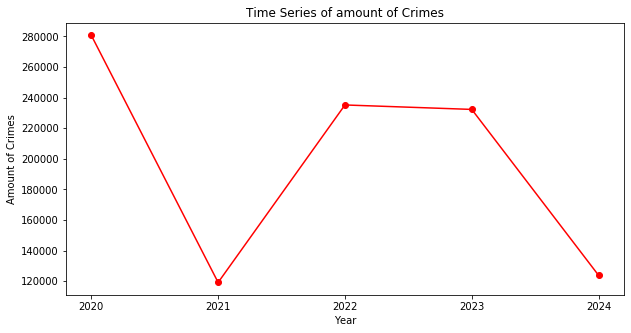

In [47]:
fig, axes = plt.subplots(figsize=(10, 5))

axes.plot(crime_per_year_df.year, crime_per_year_df.amount_of_crimes, color='red', marker="o")
axes.set_ylabel('Amount of Crimes')
axes.set_xlabel('Year')
axes.set_xticks(crime_per_year_df.year)
axes.set_title('Time Series of amount of Crimes')
plt.show()

# Highest amount of crime was in 2020, lowest in 2021

# Crime seasonality

In [48]:
seasonality = crime_data.select('month')

In [49]:
seasonality.limit(5)

month
3
2
11
3
9


In [50]:
seasonality = seasonality.groupBy('month').agg(count('month').alias('amount_of_crimes')).orderBy('month', ascending = False).toPandas()

In [51]:
seasonality

,month,amount_of_crimes
0,12,74273
1,11,77608
2,10,82774
3,9,79038
4,8,82310
5,7,82683
6,6,80703
7,5,82044
8,4,82786
9,3,87189


/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


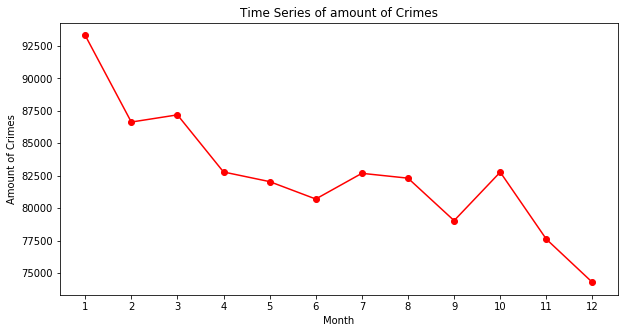

In [53]:
fig, axes = plt.subplots(figsize=(10, 5))

axes.plot(seasonality['month'], seasonality['amount_of_crimes'], color='red', marker="o")
axes.set_ylabel('Amount of Crimes')
axes.set_xlabel('Month')
axes.set_xticks(seasonality['month'])
axes.set_title('Time Series of amount of Crimes')
plt.show()

### Crime steadily drops throughout the year

# Crimes per category

In [75]:
amount_per_type = crime_data.select('Crm Cd Desc').groupby('Crm Cd Desc').agg(count('*').alias('amount_committed')).orderBy('amount_committed', ascending = False)

In [79]:
amount_per_type_df = amount_per_type.limit(10).toPandas()

In [80]:
amount_per_type_df

,Crm Cd Desc,amount_committed
0,VEHICLE - STOLEN,112393
1,BATTERY - SIMPLE ASSAULT,74349
2,BURGLARY FROM VEHICLE,62471
3,THEFT OF IDENTITY,61389
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",60191
5,BURGLARY,57722
6,THEFT PLAIN - PETTY ($950 & UNDER),52822
7,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",52558
8,INTIMATE PARTNER - SIMPLE ASSAULT,46360
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),41580


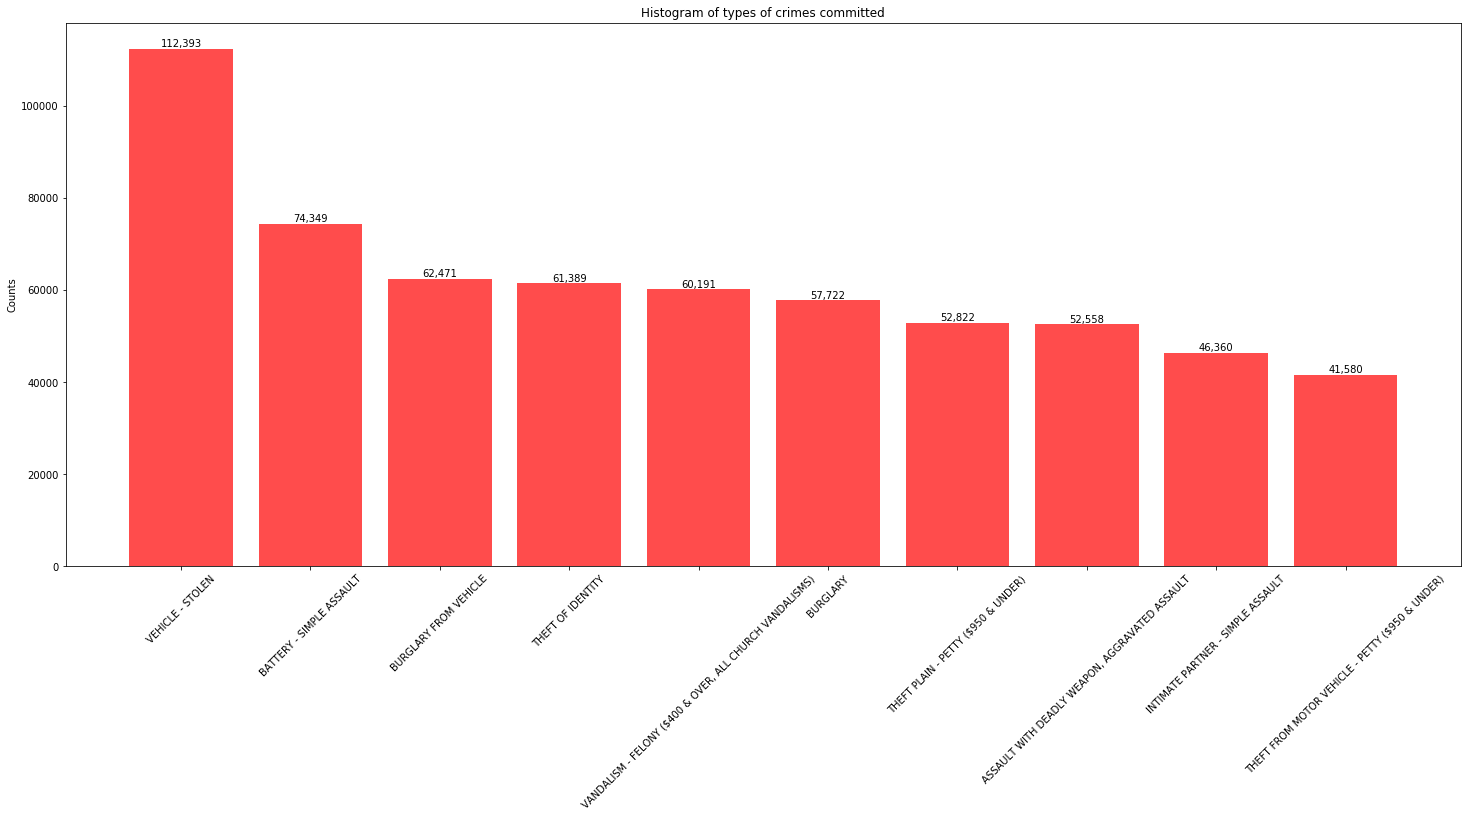

In [83]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
fig, axes = plt.subplots(figsize=(25, 10))

# Create bar chart
bars = axes.bar(
    amount_per_type_df['Crm Cd Desc'],
    amount_per_type_df['amount_committed'],
    width=0.8, color='red', alpha=0.7
)
axes.set_ylabel('Counts')
axes.set_xticklabels(amount_per_type_df['Crm Cd Desc'], rotation=45)
axes.set_title('Histogram of types of crimes committed')

# add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    axes.text(bar.get_x() + bar.get_width() / 2, height,  # x and y positions
              f'{int(height):,}', #format
              ha='center', va='bottom', fontsize=10)       # Align text

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.show()

# Types of crime over the years

In [58]:
crime_types = crime_data.select('year', 'Crm Cd Desc').groupBy('Crm Cd Desc', 'year').agg(count('Crm Cd Desc').alias('amount_of_crimes')).select(col('Crm Cd Desc').alias('crime_description'), col('year'), col('amount_of_crimes'))

In [59]:
crime_types

crime_description,year,amount_of_crimes
"DRUGS, TO A MINOR",2020,8
VEHICLE - STOLEN,2021,12850
TRESPASSING,2021,1658
BRANDISH WEAPON,2022,3494
"BUNCO, ATTEMPT",2022,65
DRIVING WITHOUT O...,2023,36
PROWLER,2024,16
BURGLARY FROM VEH...,2022,14232
BURGLARY FROM VEH...,2020,252
PROWLER,2020,65


In [62]:
types_over_time = crime_types.groupby('crime_description').pivot('year').sum('amount_of_crimes').na.fill(value=0)

In [63]:
types_over_time

crime_description,2020,2021,2022,2023,2024
GRAND THEFT / INS...,3,0,1,3,4
VANDALISM - FELON...,17618,8394,13360,13172,7647
RECKLESS DRIVING,74,48,43,66,44
DRIVING WITHOUT O...,78,16,31,36,32
DISCHARGE FIREARM...,782,425,612,650,195
PROWLER,65,27,43,54,16
THROWING OBJECT A...,276,106,173,169,61
BURGLARY FROM VEH...,252,82,132,182,63
FIREARMS RESTRAIN...,2,0,1,0,0
SODOMY/SEXUAL CON...,180,61,141,113,29


In [64]:
types_over_time_df = types_over_time.toPandas()

<Figure size 720x432 with 0 Axes>

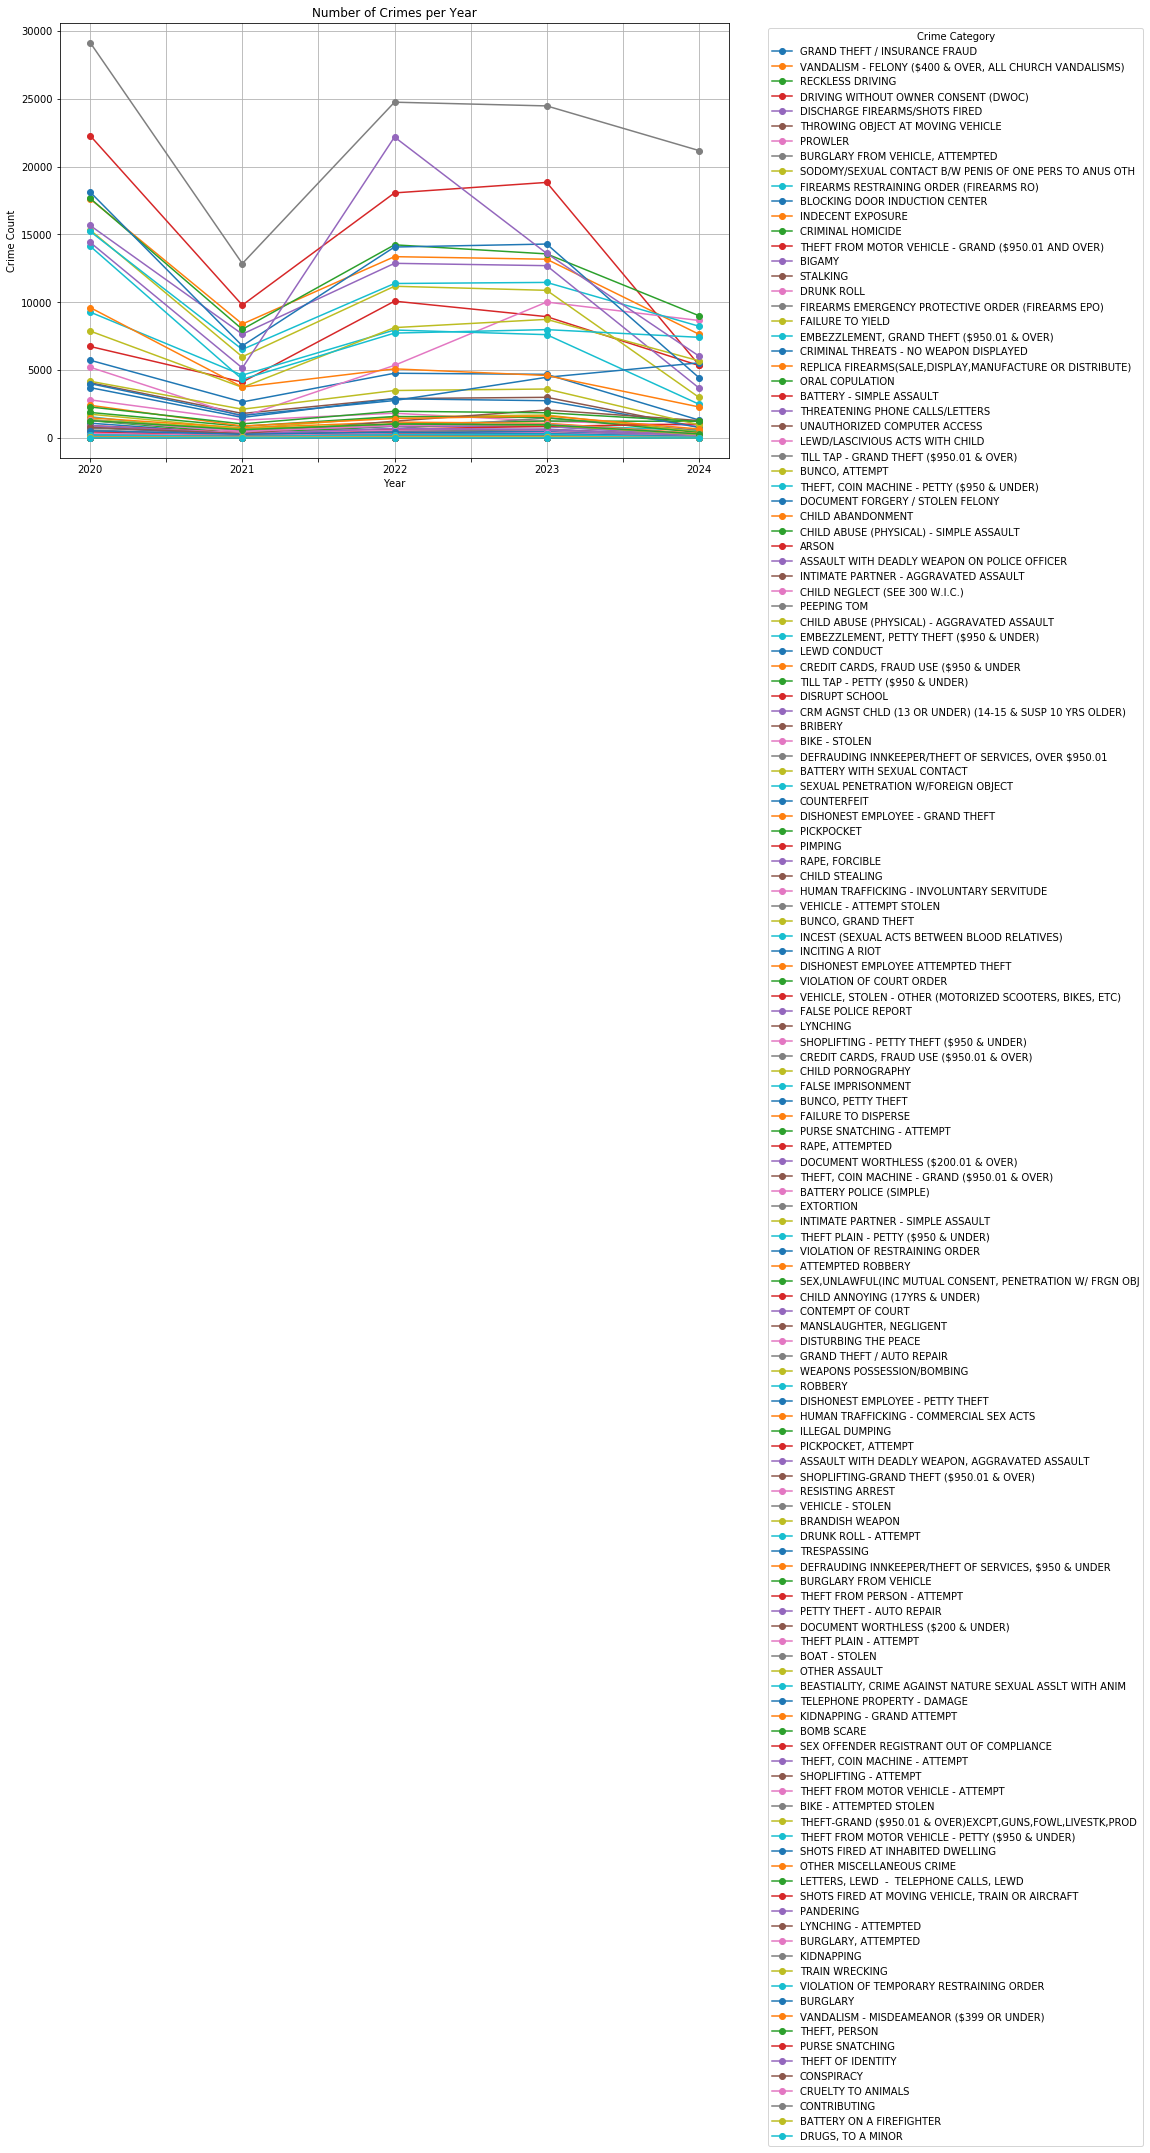

In [65]:
types_over_time_df.set_index("crime_description", inplace = True)

# Plot the line graph using Pandas and Matplotlib
plt.figure(figsize=(10, 6))
types_over_time_df.T.plot(kind="line", marker="o", figsize=(12, 8)) 
plt.title('Number of Crimes per Year')
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.legend(title="Crime Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Vehicle stolen is consistently the most popular type of crime

# Is there a correlation between the area and the type of crime committed?

In [86]:
correlation = crime_data.select('Crm Cd', 'AREA')

In [87]:
print(f'correlation between area and type of crime: {correlation.corr("Crm Cd", "AREA")}' )

correlation between area and type of crime: -0.0038676211108606235


In [93]:
print(f'correlation between age and type of crime: {crime_data.corr("Crm Cd", "Vict Age")}' )

correlation between age and type of crime: -0.020259269179305973
